**Neural Style Transfer**

It is a technique that uses deep learning to manipulate digital images or videos to adopt the appearance or visual style of another image. It takes a content image and a style reference image such as an artwork and blends them together to create a new image that looks like a content image but painted in the style of style reference image.

In this notebook leverages tenforflows hub module where we will be using pre trained model with some slight modification for neural style trasfer. To know more about [TensorFlow Hub](https://www.tensorflow.org/hub) please do read the documentation clearly.



**Setup**

Import Modules

In [ ]:
import os
import tensorflow as tf
#Load the compressed model from the tensorflow hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mat
mat.rcParams['figure.figsize'] = (12, 12)
mat.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In the below funtion **tensor_image** we do the following for an image
* Scale the tensor value to the 0-255 range
* Convert the tensor values to numpy array using uint8
* Check if the tensor has more than 3 dimensions, if it has remove the batch dimension.
* Convert the resulting numpy array to PIL image object.

In [ ]:
def tensor_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_image = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_image = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

**Visualize the image**
Defining a function for the following
* Setting a maximum dimension for the image
* Read the image file from the specified path
* Decoding the image with tensor with 3 color channels
* Convert the image data type to float32 with the pixel values in range [0,1].
* Retreave the image dimension and calculate the scaling factor to ensure dimension does not exceed 512.
* Resize the image according to the scaling factor.
* Return the processed image tensor.


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

**Define a function to diplay the image**

The below defined function "imshow" performs the following steps
1. Checks if the image tensor has more than 3 dimensions. If so, it removes the batch dimension using tf.squeeze
2. Uses matplotlib to display the image.

In [ ]:
def imshow(image,tit=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image,0)
  plt.imshow(image)

  if tit is not None:
    plt.title(tit)

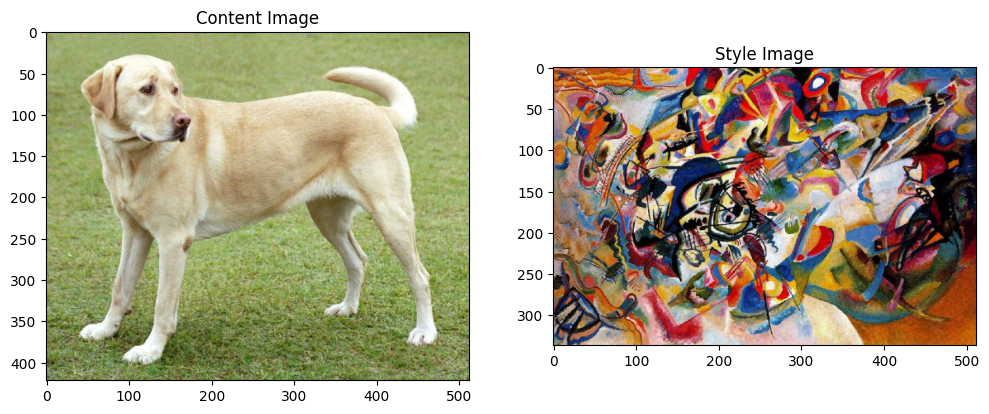

In [ ]:
content_path = load_img(content_image)
style_path = load_img(style_image)

plt.subplot(1,2,1)
imshow(content_path, 'Content Image')

plt.subplot(1,2,2)
imshow(style_path, 'Style Image')

**Stylizing the image using TensorFlow Hub**
* Load the pretrained model for arbitrary image stylization from tensorflow hub.
* Convert the content and style image into tensorflow tensors.
* Apply the model to create a stylized image that blends the content of content image and style of style image.

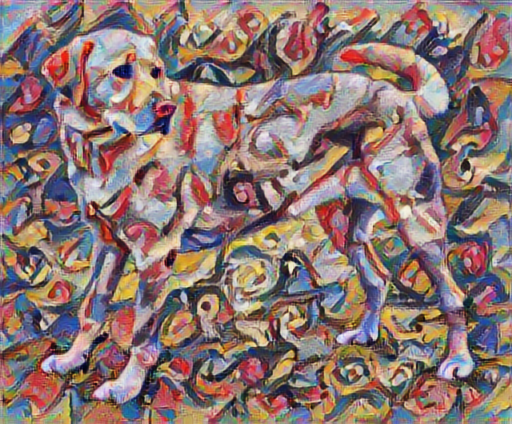

In [ ]:
import tensorflow_hub as hub
model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
styled_image = model(tf.constant(content_path),tf.constant(style_path))[0]
tensor_image(styled_image)

**Define content and style representations**

Use the intermediate layers of the model to get contents of the content image and style representations of the style image. Starting from the networks first layers, the first few layers represent low-level features such as edges and textures. And final few network represent high-level features such as objects - wheels or eyes. In this style transfer technique we will be using VGG19 network architectur, a pretrained image classification network. These intermediatery layers are required to represent the content and the style of the images.

In [ ]:
X = tf.keras.applications.vgg19.preprocess_input(content_path*255)
X = tf.image.resize(X, (224,224))
VGG = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
predictions = VGG(X)
predictions.shape

TensorShape([1, 1000])

* Now the below code "predictions.numpy" converts the Tensorflow tensors to numpy array.
* And "tf.keras.applications.vgg19.decode_predictions" decodes the predictions into human-redable probabilities and class names. It models the models output to the top predicted ImageNet classes.
* [0] extracts the top element because the predictions are for the single image.

In [ ]:
predicted_5 = tf.keras.applications.vgg19.decode_predictions(predictions.numpy())[0]
predicted_5

[('n02099712', 'Labrador_retriever', 0.4931709),
 ('n02099601', 'golden_retriever', 0.23665306),
 ('n02104029', 'kuvasz', 0.0363575),
 ('n02099849', 'Chesapeake_Bay_retriever', 0.02418278),
 ('n02107574', 'Greater_Swiss_Mountain_dog', 0.018646095)]

* Now the below line of code loads the model excluding the fully connected layers at the top of the network, which are used for classification.
* Which means only the convolutional layers of the model are loaded.
* And "weights='imagenet'" loads the pre-trained model weights from training on the ImageNet dataset.

In [ ]:
VGG = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
print()
for layer in VGG.layers:
  print(layer.name)


input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


* Now choose the intermediate layers from the network to represent content and the style of the images.
* Content Layer: Layers that will be used to exctract the contents from the content image. Now, in this case we will be using "block5_conv1".
* Style Layer: Layers that will be used to extract the styles from the style image. In this case we will be using one layer from each convolutional blocks of VGG19 model.

In [ ]:
content_layer = ['block5_conv1']

style_layer = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']

length_content = len(content_layer)
length_style = len(style_layer)

**Intermediate Layers for style and content**
Let us understand something here, why do intermediate output of the pretrained classification model allow us to define content and style representations?

* At the high level, the model to perform image classification (where this model has been trained to do so), the model must understand the image first. This requires taking the raw image pixels as the input and building the internal representation that converts this raw image pixels into complex understanding of the features present within the image.

* This is also reason why convolutional neural networks are able to generalize well. They are able to capture invariances and defining features within classes that re agnostic to background noise and other nuisances. So somewhere between where the model takes the raw image pixels as input and produces the output, the model serves as the complex feature extracter. By accessing the intermediate layers of the model, we will be able to define content and style representations of the image.

**Building the Model**
* The networks in "tf.keras.application" has been designed, so we can easily extract the intermediate layers of the model using keras functional API.

In [ ]:
def VGG_layer(layers_name):
  VGG = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  VGG.trainable = False

  output = [VGG.get_layer(name).output for name in layers_name]

  model = tf.keras.Model([VGG.input], output)

  return model

Below code is to create the model

In [ ]:
style_extractor = VGG_layer(style_layer)
style_output = style_extractor(style_path)

for name, output in zip(style_layer, style_output):
  print(name)
  print("shape:", output.numpy().shape)
  print("min:", output.numpy().min())
  print("max:", output.numpy().max())
  print()

block1_conv1
shape: (1, 336, 512, 64)
min: 0.0
max: 5.0216365

block2_conv1
shape: (1, 168, 256, 128)
min: 0.0
max: 31.935553

block3_conv1
shape: (1, 84, 128, 256)
min: 0.0
max: 75.932556

block4_conv1
shape: (1, 42, 64, 512)
min: 0.0
max: 225.93777

block5_conv1
shape: (1, 21, 32, 512)
min: 0.0
max: 34.940292



**Calculate for Style**

* Now we shall calculate some math for style using gram matrix. The contents of the image is represented by intermediate feature maps.
* It turns out, the style of a image can be describeb by the menas and correlations accross different feature maps.
* Now, calculate a gram matrix that includes this information by taking the outer product of the feature product with itself at each location, and averaging that outer product at all locations. And this gram matrix can be calculated for a particular layer.

In [ ]:
def Gram_Matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

**Extract style and Content**
* Building a model to extract the tensors of style and content images.


* Intialize a custom model for style and content extraction using VGG19.
* Scale and Pre-process the input image.
* Pass the pre-processed image VGG-model to get the intermediate output.
* Compute the Gram-matrix for style outputs.
* Return the dictionary for content and style output.


In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = VGG_layer(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Correct the nested loop in list comprehension
    style_outputs = [Gram_Matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When we call this function on an image it returns gram matrix of style_layer and content_layer.

In [ ]:
extractor = StyleContentModel(style_layer, content_layer)

result = extractor(tf.constant(content_path))
print("style")
for name, output in sorted(result['style'].items()):
  print(name)
  print("Shape:", output.numpy().shape)
  print("Minimum:", output.numpy().min())
  print("Maximum:", output.numpy().max())

print("content")
for name, output in sorted(result['content'].items()):
  print(name)
  print("Shape:", output.numpy().shape)
  print("Minimum:", output.numpy().min())
  print("Maximun:", output.numpy().max())

style
block1_conv1
Shape: (1, 64, 64)
Minimum: 0.005522845
Maximum: 28014.555
block2_conv1
Shape: (1, 128, 128)
Minimum: 0.0
Maximum: 61479.49
block3_conv1
Shape: (1, 256, 256)
Minimum: 0.0
Maximum: 545623.44
block4_conv1
Shape: (1, 512, 512)
Minimum: 0.0
Maximum: 4320501.5
block5_conv1
Shape: (1, 512, 512)
Minimum: 0.0
Maximum: 110005.36
content
block5_conv1
Shape: (1, 26, 32, 512)
Minimum: 0.0
Maximun: 4270.34


**We shall run a gradient descent algorithm now**
* With this extractor we can now implement the style transfer algorithm. We can do this by calculating the mean squared error for image's output relative to the each target, then take the weighted sum of these losses.

In [ ]:
style_target = extractor(style_path)['style']
content_target = extractor(content_path)['content']

We shall declare a variable "tf.variable" to contain the image to optimize.

In [ ]:
image = tf.Variable(content_path)

In [ ]:
def clip(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

**Create an Optimizer**

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, we will use the total weighted sum of two losses.

In [ ]:
style_weight = 1e-2
content_weight = 1e4

In [ ]:
def style_content_loss(outputs):
  style_output = outputs['style']
  content_output = outputs['content']
  style_loss = tf.add_n([tf.reduce_mean((style_output[name]-style_target[name])**2)
                           for name in style_output.keys()])
  style_loss *= style_weight / length_style

  content_loss = tf.add_n([tf.reduce_mean((content_output[name]-content_target[name])**2)
                             for name in content_output.keys()])
  content_loss *= content_weight / length_content
  loss = style_loss + content_loss
  return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip(image))

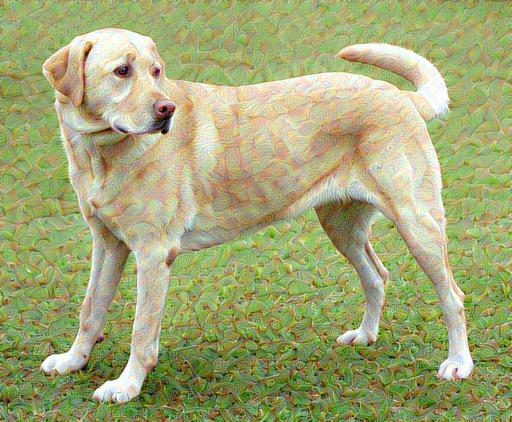

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_image(image)

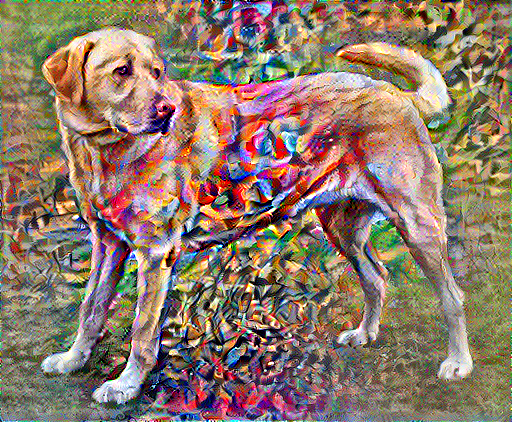

Train step: 1000
Total time: 73.2


In [ ]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

**Total Variation Loss**

One downside this basic implementation is that it produces lot of high frequecy artifacts. And we can decrease this by using explicit regularization term on the high frequency components of the image. In the context of style transfer this is often called total variation loss.

In [ ]:
file_name = 'stylized-image.png'
tensor_image(image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

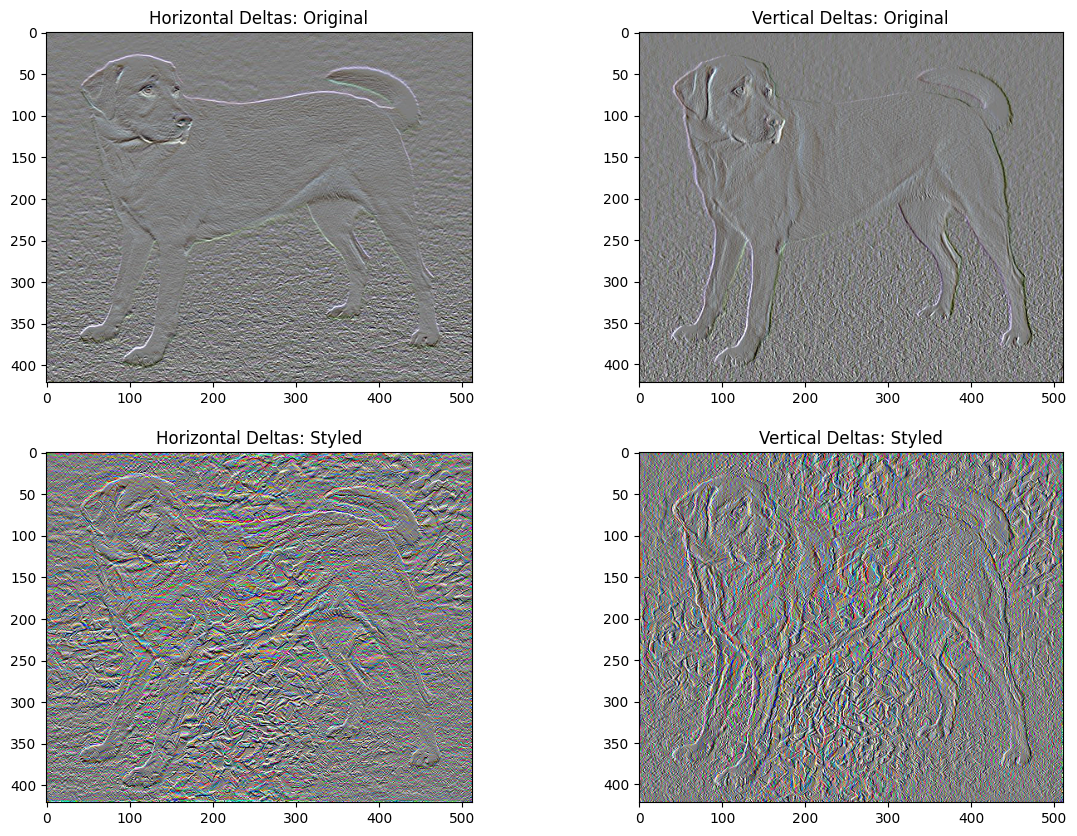

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_path)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip(2*x_deltas+0.5), "Vertical Deltas: Styled")

Also this high frequency detector is just an edge detector, we can get the same output using sobel edge detector

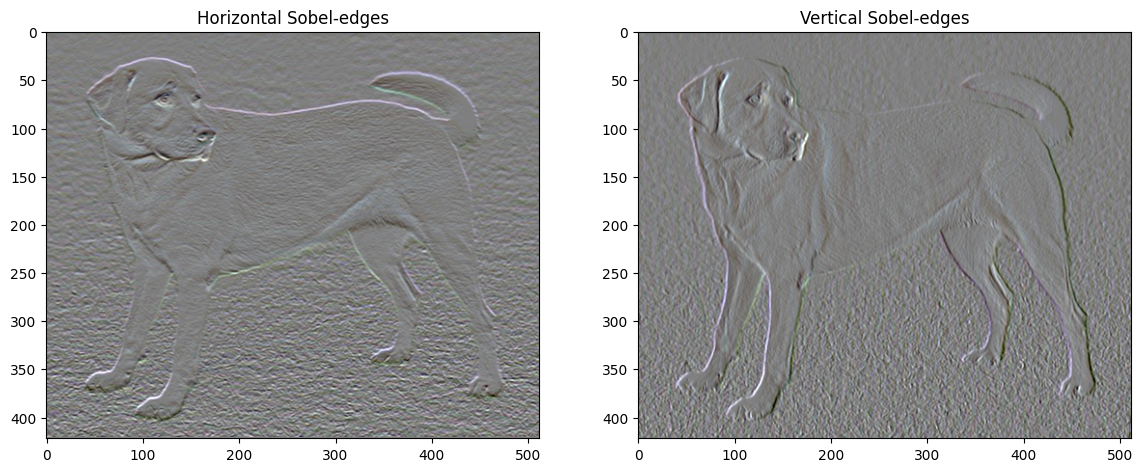

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_path)
plt.subplot(1, 2, 1)
imshow(clip(sobel[..., 0]/4+0.5), "Horizontal Sobel-edges")
plt.subplot(1, 2, 2)
imshow(clip(sobel[..., 1]/4+0.5), "Vertical Sobel-edges")

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
total_variation_loss(image).numpy()

152845.45

In [ ]:
tf.image.total_variation(image).numpy()

array([152845.45], dtype=float32)

**Re-run the optimization**

We shall re-run the optimization with total variation loss by choosing a different weight

In [ ]:
total_variation_weight=30

In [ ]:
#Now we shall include this in the training step function

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip(image))

In [ ]:
image = tf.Variable(content_path)
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>